# Fakenews detection
Karolina Mączka, Tymoteusz Urban

<h1 style="color:red"> Komentarze dotyczące walidacji oznaczane są kolorem czerwonym. </h1>
lub symbolem /A/


<span style="color:red"> walidacja: Aleks Kapich, Tymoteusz Kwieciński</span>


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import re
from wordcloud import WordCloud
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 0

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tymot\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tymot\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tymot\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\tymot\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [8]:
# Upload danych
train=pd.read_csv('training_data.csv', header=0, sep=',')
test=pd.read_csv('testing_data.csv', header=0, sep=',')
val=pd.read_csv('fakenws_validation.csv', header=0, sep=',')

In [9]:
len(train)/sum([len(df) for df in [train, test, val]])

0.4899847925266131

<span style="color:red">Zbiór treningowy to niecałe 50% całego zbioru danych - mógłby być trochę większy,
przy zbyt małym zbiorze treningowym model może funkcjonować nieefektywnie</span> 

## Train test split

<span style="color:red">Zweryfikujmy, czy wartości z targetu są rozdystrybuowane podobnie w zbiorach train, test, val</span> 

In [10]:
for target in [train['label'], test['label'], val['label']]:
    print(target.value_counts())
    print('Proporcja true/fake:',
          len(target[target=='true'])/len(target[target=='fake']),
          '\n')

fake    20645
true    13186
Name: label, dtype: int64
Proporcja true/fake: 0.6387018648583193 

fake    12700
true     8014
Name: label, dtype: int64
Proporcja true/fake: 0.631023622047244 

fake    8814
true    5686
Name: label, dtype: int64
Proporcja true/fake: 0.6451100521896982 



<span style="color:red">Proporcje w targecie są zachowane w każdym ze zbiorów danych - bardzo dobrze</span>  

In [11]:
df_train = train.copy()
df_testing = test.copy()
df_validate= val.copy()

In [12]:
df2 = df_validate # ułatwienie pracy z notebookiem

## Getting to know the data


In [13]:
df2.head()

,title,text,label
0,"They Said What?!: Find Out What Reba McEntire,...",Email Ever wonder what’s on the mind of today’...,fake
1,Macron's European dream more difficult without...,PARIS (Reuters) - President Emmanuel Macron s ...,true
2,FLASHBACK VIDEO: JESSE JACKSON Praises Donald ...,Oops! Hillary and her race-baiting campaign te...,fake
3,Markets ignore Trump presidential bid at their...,LONDON (IFR) - The prospect of Donald Trump be...,true
4,Dem insiders: Sanders failed to dent Clinton,"Killing Obama administration rules, dismantlin...",true


In [14]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14500 entries, 0 to 14499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   14368 non-null  object
 1   text    14486 non-null  object
 2   label   14500 non-null  object
dtypes: object(3)
memory usage: 340.0+ KB


<span style="color:red">Nie ma braków w targecie, specyficzny zbiór danych wymagający przetworzenia adekwatnego dla NLP.
Niewielka ilość braków w kolumnach text i title, szczególnie braki w 'text' zwracają uwage bo to kluczowa kolumna</span>   



## Data Preprocessing

### Encoding

In [15]:
# zamina fake i true na wartości numeryczne
df2.loc[df2["label"] == "fake","label"] = 0
df2.loc[df2["label"] == "true","label"] = 1

In [16]:
# before pipeline function
def encodeLabels(df):
    df.loc[df["label"] == "fake","label"] = 0
    df.loc[df["label"] == "true","label"] = 1
    return df

### NaNs

<span style="color:red">Lepiej wstępnie przeanalizować jak wyglądają braki danych, zamiast od razu się ich pozbywać - nie ma dowodu na to, że eksploracja braków danych została wykonana - a mogą zawierać one pewne informacje</span>    

In [17]:
# /A/ przyjrzenie się tytułom bez tekstu
df2[df2['text'].isna()]['title']

257      Il saoule tout le monde avec son analyse polit...
926                            Ravens @ Raiders - Thursday
989      New U.N. Report Cites Terrorists, Blames Assad...
1083                    The Prophet of Germany’s New Right
1411     La Corée du Nord annonce avoir envoyé un missi...
2663     La Trump Tower cambriolée – les voleurs seraie...
3061     Donald Trump s’excuse pour toutes les minorité...
4208     La sortie du dernier livre inédit du Gorafi éc...
6446     Le top des recherches Google passe en top des ...
9348     10/6 Post-Season: WS: Beat Boston,Lose Two To ...
12115                 Donald Trump en 5 dates >> Le Gorafi
12266    Sur Twitter, Donald Trump se félicite d’avoir ...
13236    10/4 Expo Park-Forbes Field Era: '08 To the Wi...
13493    La Russie a profité de l’élection américaine p...
Name: title, dtype: object

In [18]:
# /A/ przyjrzenie się tekstom bez tytułu
df2[df2['title'].isna()]['text']

146      A leading US senator: US Supporting War in Syr...
282      They’re too busy liking bullshit memes and wat...
308      $2.9B/year could have taken care of many highw...
512      Lying, arrogant Muslim, Marxist piece of dogsh*t.
620      There are a ton of tards who will continue to ...
                               ...                        
13919    Wait till you see what happens to the valuatio...
13995    JUST VOTE TRUMP LETs PUT THE HAG OUT TO PASTUR...
14070      Yes... AARP opposed Single Payer. Boycott them.
14316    Same people all the time , i dont know how you...
14452    A leading US senator: US Supporting War in Syr...
Name: text, Length: 132, dtype: object

In [19]:
# Jest bardzo mało nulli więc możemy się ich pozbyć
df2.dropna(inplace = True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14354 entries, 0 to 14499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   14354 non-null  object
 1   text    14354 non-null  object
 2   label   14354 non-null  object
dtypes: object(3)
memory usage: 448.6+ KB


<span style="color:red">Jak widać brak tytułu, ani brak tekstu nie oznaczają braku żadnych informacji o obserwacji</span>    

In [20]:
# transformer function
def handleNa(df):
    df.dropna(inplace=True)
    print('NaNs deleted')
    return df

### Combine columns

In [21]:
# Z racji, że będziemy analizować same słowa, łączymy kolumny title i tekst 
# - dla naszego modelu nie będzie miało znaczenia z której kolumny pochodzą

<span style="color:red">Dobry pomysł, ale pozostawienie kolumny title też mogłoby nieść dodatkowe informacje - tytuły często mogą mieć *clickbaitowy* charakter</span>    

In [22]:
df2.loc[8102]

title    ALL HELL IS BREAKING LOOSE IN GERMANY: Citizen...
text     Enough is enough! German citizens are witnessi...
label                                                    0
Name: 8102, dtype: object

In [23]:
df2['text'] = df2[['title', 'text']].apply(" ".join, axis=1)

In [24]:
df2.loc[8102]['text']

'ALL HELL IS BREAKING LOOSE IN GERMANY: Citizens Want “Refugees” Gunned Down At Borders [VIDEO] Enough is enough! German citizens are witnessing the fast-track decline of their nation. Does America need to look any further than Germany to see that bringing in hundreds of thousands (in Germany s case millions) of Muslim men from countries who have no interest in assimilating in the Western world, is a serious threat to its citizens?  Liberal open-border policies that have been put forth by Angel Merkel and other progressives in power have clearly put their citizens in grave danger. OVER one-in-four Germans say they back a policy to open fire on unwanted illegal refugees at their borders.Watch massive brawl break out in refugee camp over torn Quran:The Alternative for Germany (AFD) party leader Frauke Petry caused a storm a week ago when she advocated the right of border police to gun down migrants. But her comments have struck a nerve in a country being pushed to the brink by the crisis

In [25]:
#df2 = df2.drop(columns='title')

In [26]:
# /A/ przykładowy kod który można wykorzystać do sprawdzenia ile wielkich liter w tytule
def uppercase_percentage(text):
    if not isinstance(text, float) : # sprawdzamy czy wartość nie jest pusta
        return(sum(1 for c in text if c.isupper())/len(text))

def count_uppercase_percentage(df):
    df['title_uppercase_percentage'] = df['title'].apply(uppercase_percentage)

count_uppercase_percentage(df2)

In [27]:
df2.head(5)

,title,text,label,title_uppercase_percentage
0,"They Said What?!: Find Out What Reba McEntire,...","They Said What?!: Find Out What Reba McEntire,...",0,0.184783
1,Macron's European dream more difficult without...,Macron's European dream more difficult without...,1,0.047619
2,FLASHBACK VIDEO: JESSE JACKSON Praises Donald ...,FLASHBACK VIDEO: JESSE JACKSON Praises Donald ...,0,0.314516
3,Markets ignore Trump presidential bid at their...,Markets ignore Trump presidential bid at their...,1,0.038462
4,Dem insiders: Sanders failed to dent Clinton,Dem insiders: Sanders failed to dent Clinton K...,1,0.068182


In [28]:
# transformer function
def combineColumns(df):
    df['text'] = df[['title', 'text']].apply(" ".join, axis=1)
    df = df.drop(columns='title')
    print('Columns combined')
    return df

### Outliers

(array([1.3511e+04, 6.7900e+02, 9.0000e+01, 4.9000e+01, 6.0000e+00,
        8.0000e+00, 6.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00]),
 array([1.40000e+01, 7.51640e+03, 1.50188e+04, 2.25212e+04, 3.00236e+04,
        3.75260e+04, 4.50284e+04, 5.25308e+04, 6.00332e+04, 6.75356e+04,
        7.50380e+04]),
 <BarContainer object of 10 artists>)

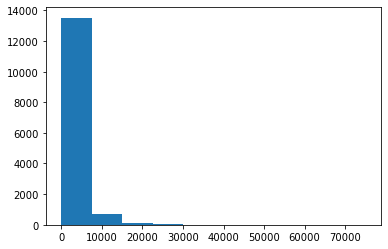

In [29]:
df2['textlength'] = df2['text'].apply(len)
plt.hist(df2['textlength'])

In [30]:
print(df2[(df2['textlength'] > 40000)].count())
df2[(df2['textlength'] > 40000)].head()

title                         18
text                          18
label                         18
title_uppercase_percentage    18
textlength                    18
dtype: int64


,title,text,label,title_uppercase_percentage,textlength
72,Increasing Sentience,Increasing Sentience Leave a reply \r\nLisa Re...,0,0.100000,58200
248,Re: Prescription Painkiller Crisis: Why Do Ame...,Re: Prescription Painkiller Crisis: Why Do Ame...,0,0.125000,69571
498,Inside the war on coal,Inside the war on coal The war on coal is not ...,1,0.045455,41076
873,Re: More Americans Than Ever Are Losing Their ...,Re: More Americans Than Ever Are Losing Their ...,0,0.166667,66130
1513,LUCIFER in the Temple of the Dog II,LUCIFER in the Temple of the Dog II ISIS Takes...,0,0.314286,47319


In [31]:
# Wyrzucamy bardzo dlugie teksty (ponad 40000 znaków)
df2 = df2[(df2['textlength'] < 40000)]
df2.drop(columns='textlength')

,title,text,label,title_uppercase_percentage
0,"They Said What?!: Find Out What Reba McEntire,...","They Said What?!: Find Out What Reba McEntire,...",0,0.184783
1,Macron's European dream more difficult without...,Macron's European dream more difficult without...,1,0.047619
2,FLASHBACK VIDEO: JESSE JACKSON Praises Donald ...,FLASHBACK VIDEO: JESSE JACKSON Praises Donald ...,0,0.314516
3,Markets ignore Trump presidential bid at their...,Markets ignore Trump presidential bid at their...,1,0.038462
4,Dem insiders: Sanders failed to dent Clinton,Dem insiders: Sanders failed to dent Clinton K...,1,0.068182
...,...,...,...,...
14495,"Bill O'Reilly claims false, admits Fox News: W...","Bill O'Reilly claims false, admits Fox News: W...",1,0.093333
14496,Inside Jeb's 'shock and awe' launch,Inside Jeb's 'shock and awe' launch A verdict ...,1,0.057143
14497,"London museum says serious incident outside, w...","London museum says serious incident outside, w...",1,0.015625
14498,GAME CHANGER? Trump Recruits Election “Observe...,GAME CHANGER? Trump Recruits Election “Observe...,0,0.224490


<span style="color:red">Nie jestem pewien czy to jest niezbędne podejscie - ten rozklad po dodaniu binsów wyglada raczej okej. Dodatkowo bardzo długich tekstów jest bardzo niewiele (może warto było zweryfikować czego dotyczą przed wyrzuceniem) </br></br> Być może ich eliminacja nie jest konieczna</span>  

(array([455., 507., 700., 648., 461., 461., 520., 544., 635., 697., 805.,
        769., 779., 714., 540., 487., 424., 352., 295., 280., 274., 234.,
        201., 198., 214., 193., 164., 145., 119., 108.,  94.,  96.,  80.,
         67.,  68.,  64.,  59.,  51.,  66.,  39.,  48.,  36.,  42.,  38.,
         19.,  34.,  34.,  25.,  23.,  20.,  29.,  20.,  13.,  14.,  12.,
         13.,  14.,   9.,  11.,  16.,  10.,   4.,  18.,   9.,  12.,  13.,
          2.,   6.,   2.,   9.,  10.,   7.,   4.,   1.,   3.,   3.,   3.,
          4.,   3.,   4.,   3.,   4.,   2.,   0.,   1.,   4.,   3.,   2.,
          4.,   5.,   2.,   6.,   2.,   2.,   1.,   1.,   2.,   0.,   3.,
          3.,   2.,   0.,   4.,   1.,   1.,   1.,   1.,   1.,   2.,   0.,
          2.,   5.,   4.,   2.,   1.,   1.,   1.,   2.,   0.,   3.,   0.,
          1.,   3.,   1.,   2.,   1.,   1.,   3.,   1.,   1.,   0.,   0.,
          0.,   3.,   4.,   2.,   0.,   7.,   2.,   1.,   1.,   2.,   1.,
          2.,   0.,   1.,   1.,   0., 

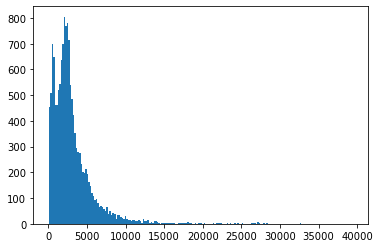

In [32]:
plt.hist(df2['textlength'], bins=200) # na tym wykresie widać, że rozkład ten wygląda w miare dobrze - 

In [33]:
# transformer function
def removeOutliers(df):
    df['textlength'] = df['text'].apply(len)
    df = df[df['textlength'] < 40000]
    df = df.drop(columns='textlength')
    print('Outliers removed')
    return df

### Removing stopwords

In [34]:
#stopword removal
stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
def remove_stopwords(s):
    s = [lemmatizer.lemmatize(word.lower()) for word in s if not word.lower() in stop]
    return s

In [35]:
# punctuation and number removal
def remove_punctuations(s):
    s = re.sub(r'[^a-zA-Z\s]', '', s)
    return s

In [36]:
df2['text'] = df2['text'].apply(remove_punctuations)
df2['text'] = df2['text'].apply(word_tokenize)

<ipython-input-36-1f65a2a80bc5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['text'] = df2['text'].apply(remove_punctuations)
<ipython-input-36-1f65a2a80bc5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['text'] = df2['text'].apply(word_tokenize)


In [37]:
df2['text'] = df2['text'].apply(remove_stopwords)

<ipython-input-37-5a8075b3df85>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['text'] = df2['text'].apply(remove_stopwords)


<span style="color:red">Odpowiednie podejście w wypadku NLP, dobrze że tekst został stokenizowany i usunięto interpunkcję</span>  

In [38]:
def list2string(text):
    text = " ".join(wrd for wrd in text)
    return text

In [39]:
df3 = df2.copy()

In [40]:
df3["text"] = df3["text"].apply(list2string)
df3.head()

,title,text,label,title_uppercase_percentage,textlength
0,"They Said What?!: Find Out What Reba McEntire,...",said find reba mcentire whoopi goldberg pope f...,0,0.184783,1181
1,Macron's European dream more difficult without...,macron european dream difficult without strong...,1,0.047619,1837
2,FLASHBACK VIDEO: JESSE JACKSON Praises Donald ...,flashback video jesse jackson praise donald tr...,0,0.314516,879
3,Markets ignore Trump presidential bid at their...,market ignore trump presidential bid peril lon...,1,0.038462,3198
4,Dem insiders: Sanders failed to dent Clinton,dem insider sander failed dent clinton killing...,1,0.068182,162


In [41]:
# transformer function
def removeStopwords(df):
    df['text'] = df['text'].apply(remove_punctuations)
    print('Punctuation removed')
    df['text'] = df['text'].apply(word_tokenize)
    print('Words tokenized')
    df['text'] = df['text'].apply(remove_stopwords)
    print('Stopwords removed')
    df['text'] = df['text'].apply(list2string)
    return df

### Extracting english

In [46]:
def deleteUrl(text):
    return re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', text)

<span style="color:red">Według mnie szkoda tracić informację o liczbie linków w tekście - może się okazać wartościowa.
Na potrzeby poniższej analizy mówiącej, które z tekstów były samymi linkami można by utworzyć po prostu
nową kolumnę, gdzie znajdowałby się tekst bez linków</span> 

In [43]:
# /A/ przykładowy kod służący do policzenia wystąpień linków

# /A/ potrzebujemy stokenizowanego tekstu
df3['tokenized_text'] = df3['text'].apply(word_tokenize)

def count_urls(df):
    df['url_amount'] = df['tokenized_text'].apply(
        lambda row: len([word for word in row if 'http' in word or 'https' in word])
    )

In [44]:
# /A/
count_urls(df3)
df3.head(5)

,title,text,label,title_uppercase_percentage,textlength,tokenized_text,url_amount
0,"They Said What?!: Find Out What Reba McEntire,...",said find reba mcentire whoopi goldberg pope f...,0,0.184783,1181,"[said, find, reba, mcentire, whoopi, goldberg,...",0
1,Macron's European dream more difficult without...,macron european dream difficult without strong...,1,0.047619,1837,"[macron, european, dream, difficult, without, ...",0
2,FLASHBACK VIDEO: JESSE JACKSON Praises Donald ...,flashback video jesse jackson praise donald tr...,0,0.314516,879,"[flashback, video, jesse, jackson, praise, don...",1
3,Markets ignore Trump presidential bid at their...,market ignore trump presidential bid peril lon...,1,0.038462,3198,"[market, ignore, trump, presidential, bid, per...",0
4,Dem insiders: Sanders failed to dent Clinton,dem insider sander failed dent clinton killing...,1,0.068182,162,"[dem, insider, sander, failed, dent, clinton, ...",0


In [47]:
# usuwamy linki
df3['text'] = df3['text'].apply(deleteUrl)

In [48]:
# tworzymy krótszą kolumnę do analizy języka
def shortenText(text):
    return text[:60]

In [49]:
df3['shorttext'] = df3['text'].apply(shortenText)

In [50]:
df3['shorttext'][1]

'macron european dream difficult without strong germany paris'

In [51]:
df3[df3['shorttext'].apply(len) < 10]

,title,text,label,title_uppercase_percentage,textlength,tokenized_text,url_amount,shorttext
638,Политизация проблемы терроризма на саммите БРИ...,g,0,0.092105,6195,[g],0,g
1440,О принцессах — ни слова!,,0,0.041667,3149,[],0,
1919,Трамп разбушевался,,0,0.055556,2498,[],0,
2442,Переплюнуть Калигулу…,,0,0.095238,2385,[],0,
3188,Когда за скандалами не разглядеть таланта,,0,0.024390,2855,[],0,
4574,Что Джон Керри забыл на Южном полюсе? | Новое ...,,0,0.076923,2236,[],0,
4900,СМИ: в России создадут систему для отслеживани...,,0,0.059524,1274,[],0,
5531,А не стоит ли оставить США наедине со своими «...,,0,0.049505,1160,[],0,
5613,С любовью… С природой…,,0,0.090909,2937,[],0,
6497,Дмитрий Савельев: Наказание для посягнувших на...,pravdaru,0,0.037975,2189,[pravdaru],0,pravdaru


In [52]:
# usuwamy teksty które mają mniej niż 10 znaków - były to same linki
df3 = df3[df3['shorttext'].apply(len) > 10]

<span style="color:red">Usunięcie bardzo krótkich tekstów ma sens</span> 

In [53]:
df3.head()

,title,text,label,title_uppercase_percentage,textlength,tokenized_text,url_amount,shorttext
0,"They Said What?!: Find Out What Reba McEntire,...",said find reba mcentire whoopi goldberg pope f...,0,0.184783,1181,"[said, find, reba, mcentire, whoopi, goldberg,...",0,said find reba mcentire whoopi goldberg pope f...
1,Macron's European dream more difficult without...,macron european dream difficult without strong...,1,0.047619,1837,"[macron, european, dream, difficult, without, ...",0,macron european dream difficult without strong...
2,FLASHBACK VIDEO: JESSE JACKSON Praises Donald ...,flashback video jesse jackson praise donald tr...,0,0.314516,879,"[flashback, video, jesse, jackson, praise, don...",1,flashback video jesse jackson praise donald tr...
3,Markets ignore Trump presidential bid at their...,market ignore trump presidential bid peril lon...,1,0.038462,3198,"[market, ignore, trump, presidential, bid, per...",0,market ignore trump presidential bid peril lon...
4,Dem insiders: Sanders failed to dent Clinton,dem insider sander failed dent clinton killing...,1,0.068182,162,"[dem, insider, sander, failed, dent, clinton, ...",0,dem insider sander failed dent clinton killing...


In [54]:
df4 = df3.copy()

In [55]:
DetectorFactory.seed = 0
df4['lang'] = df4['shorttext'].apply(detect)

In [56]:
# /A/ Weryfikacja
len(df4[df4['lang']!='en'])/len(df4)

0.1293567088077111

<span style="color:red">Dobrze zweryfikować jaki procent naszych danych zostanie usunięty</span> 

In [57]:
# robimy model który będzie wykrywał po angielsku
df4 = df4[df4['lang']=='en']

In [58]:
df4 = df4[['text', 'label']].reset_index(drop=True)
df4

,text,label
0,said find reba mcentire whoopi goldberg pope f...,0
1,macron european dream difficult without strong...,1
2,flashback video jesse jackson praise donald tr...,0
3,calgary airport arrival yyc support u calgary ...,0
4,van jones explains rachel maddows dont actuall...,0
...,...,...
12460,bill oreilly claim false admits fox news wont ...,1
12461,inside jebs shock awe launch verdict could swe...,1
12462,london museum say serious incident outside wor...,1
12463,game changer trump recruit election observer p...,0


In [59]:
#transformer function
def dropLanguages(df):
    DetectorFactory.seed = 0
    df['text'] = df['text'].apply(deleteUrl)
    df['shorttext'] = df['text'].apply(shortenText)
    df = df[df['shorttext'].apply(len) > 10]
    print('Text cleaned')
    df['lang'] = df['shorttext'].apply(detect)
    df = df[df['lang']=='en']
    df = df.drop(columns=['shorttext', 'lang'])
    print('Languages dropped')
    return df

In [60]:
# żeby zapisać dane
df4.to_csv('train_data.csv', index=False)

### Word Cloud

In [61]:
df_fake = df4[df4["label"] == 0]
df_true = df4[df4["label"] == 1]

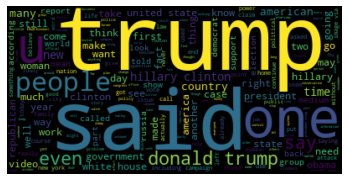

In [62]:
# Fałszywe
consolidated_f = ' '.join(
    word for word in df_fake['text'].astype(str))
wordcloud = WordCloud().generate(consolidated_f)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

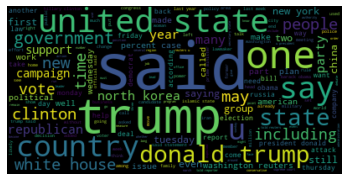

In [63]:
# Prawdziwe
consolidated_t = ' '.join(
    word for word in df_true['text'].astype(str))
wordcloud = WordCloud().generate(consolidated_t)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<span style="color:red">Ogólnie sama idea zweryfikowania jakie słowa pojawiają się w fake newsach i prawdziwych informacjach
jest według mnie bardzo trafna i można w ten sposób wyciągnąć użyteczne dane. </br> </br>
Jedyne co bym zmienił, to sposób analizy tych danych - word cloud jest dosyć chaotyczny.
Zamiast tego może lepiej by było zrobić np. listy top 100 w obydwu kategoriach i zweryfikować jak bardzo
pokrywają się. 
</span> 

In [64]:
# Bag of words - liczba wystąpień każdego słowa w danym tekście
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df4['text'])

In [65]:
#Transformer function
def myCountVectorizer(df):
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(df['text'])

In [66]:
# Zamiana częstości w częstotliwość wystąpień
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [67]:
X_train_tfidf.shape

(12465, 109953)

## Pipeline

In [68]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

na_transformer = FunctionTransformer(handleNa)
column_transformer = FunctionTransformer(combineColumns)
outliers_transformer = FunctionTransformer(removeOutliers)
stopwords_transformer = FunctionTransformer(removeStopwords)
language_transformer = FunctionTransformer(dropLanguages)

custom_pipe = Pipeline([
    ("na", na_transformer),
    ('columns', column_transformer),
    ('outliers', outliers_transformer),
    ("stopwords", stopwords_transformer),
    ("language", language_transformer),
])

model_pipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])

In [69]:
train = pd.read_csv('training_data.csv', index_col=False)

In [70]:
train

,title,text,label
0,In the Western World Respect for Law No Longer...,In the Western World Respect for Law No Longer...,fake
1,"WATCH: President Obama Unleashes On Trump, Sa...",During an interview on CBS s Face the Nation S...,fake
2,THE GUY WHO Punched “Moldylocks” Speaks Out Ab...,Nathan Domingo is the founder of Identity Eur...,fake
3,SAY WHAT? AMAZON TELLS CUSTOMER THEY WERE FORC...,"When it comes to limiting our free speech, not...",fake
4,ANTI-GUN Zealot KATIE COURIC Hit With $12 MILL...,Little Miss Sunshine has fooled a lot of peo...,fake
...,...,...,...
33826,STATE’S ATTORNEY LIED: BALTIMORE POLICE HAD PR...,Marilyn Mosby held a press conference today in...,fake
33827,Russia denies its planes killed civilians in S...,MOSCOW (Reuters) - Russia s Defence Ministry d...,true
33828,Hungary’s “Wall” Versus the U.S. “Wall”,Op-Ed by Catherine J. Frompovich\r\nCurrently ...,fake
33829,Pastor Caught Trump’s Spiritual Advisor Steal...,It seems that Donald Trump s spiritual advisor...,fake


In [71]:
train = encodeLabels(train)

In [72]:
train_transformed = custom_pipe.transform(train)

NaNs deleted
Columns combined
Outliers removed
Punctuation removed
Words tokenized
Stopwords removed
Text cleaned
Languages dropped


<ipython-input-59-6de31874f3e2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lang'] = df['shorttext'].apply(detect)


In [73]:
train_transformed

,text,label
0,western world respect law longer exists wester...,0
1,watch president obama unleashes trump say terr...,0
2,guy punched moldylocks speaks violent antifa f...,0
3,say amazon tell customer forced federal govern...,0
5,trump crisis lewd remark woman come light new ...,1
...,...,...
33825,trump give brutal warning lawless sanctuary ci...,0
33826,state attorney lied baltimore police probable ...,0
33828,hungary wall versus u wall oped catherine j fr...,0
33829,pastor caught trump spiritual advisor stealing...,0


In [74]:
train_transformed_x = train_transformed['text']
train_transformed_y = train_transformed['label']

In [75]:
train_xx = model_pipe.fit_transform(train_transformed_x, train_transformed_y)

In [76]:
train_xx.shape

(29070, 178186)

<span style="color:red">Ogólnie rzecz biorąc w porządku analiza i preprocessing dość specyficznych danych dotyczących języka. Brakuje pewnego rodzaju wnikliwości w eksploracji danych, ale  najważniejsze elementy analizy tekstu zostały przygotowane dobrze.
</span> 